In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-05-30 18:43:10.397065


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  1
2.10.0


# Scan data folders


In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"{dirpath} contains {len(dirnames)} files and {len(filenames)} images \n")

pizza_steak contains 2 files and 0 images 

pizza_steak\test contains 2 files and 0 images 

pizza_steak\test\pizza contains 0 files and 250 images 

pizza_steak\test\steak contains 0 files and 250 images 

pizza_steak\train contains 2 files and 0 images 

pizza_steak\train\pizza contains 0 files and 750 images 

pizza_steak\train\steak contains 0 files and 750 images 


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [5]:
import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd


In [6]:
data_dir = pathlib.Path("pizza_steak/train/")
for item in data_dir.glob('*'):
    print(item.name)
class_names= np.array([item.name for item in data_dir.glob('*')])
print(f'class names : \n {class_names}')

pizza
steak
class names : 
 ['pizza' 'steak']


image shape : (512, 382, 3)


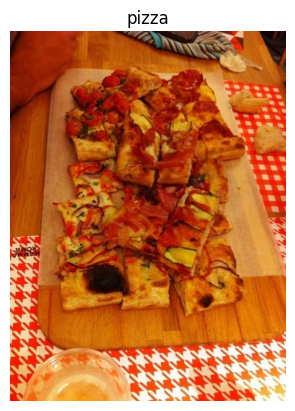

In [7]:
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    target_folder = target_dir+target_class
    # print(target_folder)
    
    random_image = random.sample(os.listdir(target_folder),2 ) # k = 2 nb of elements selected
    img= mpimg.imread(target_folder + '/' +random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off') # disable axis values
    
    print(f'image shape : {img.shape}')
view_random_image(target_dir='pizza_steak/train/', target_class='pizza')

# Data preprocessing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (normalization, standarization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               seed=42
)  
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='binary',
                                               seed=42
)           


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [9]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [10]:
print(len(train_data))

47


In [11]:
train_data

# Create the model

In [12]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3),activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.binary_crossentropy,
               metrics=['accuracy'])


In [13]:
with tf.device('/GPU:0'):  # Use the first GPU

    history1= model1.fit(train_data,
                         epochs=1,
                         steps_per_epoch=len(train_data),
                         validation_data=valid_data,
                         validation_steps=len(valid_data))

47/47 [==============================] - 8s 118ms/step - loss: 0.5450 - accuracy: 0.7320 - val_loss: 0.4348 - val_accuracy: 0.8220


# Evaluate the model

<Axes: >

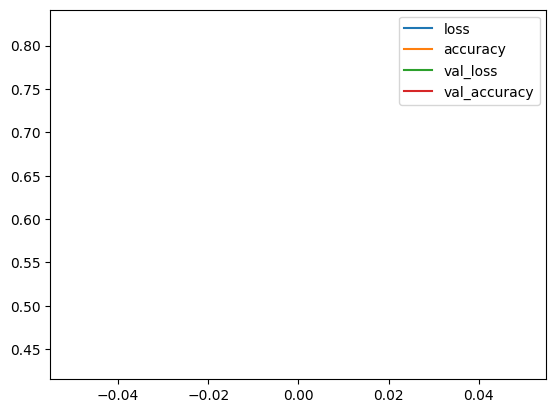

In [14]:
pd.DataFrame(history1.history).plot()

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                    

# Improve the model
#### Data augmentation

In [16]:
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True,
                                             vertical_flip=False
)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



In [17]:
train_datagen_augmented

In [18]:
print('Augmented training images : ')
train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images : 
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [19]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels  = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

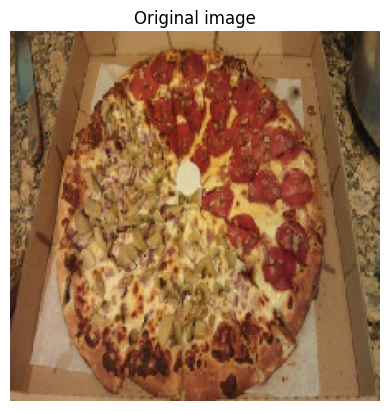

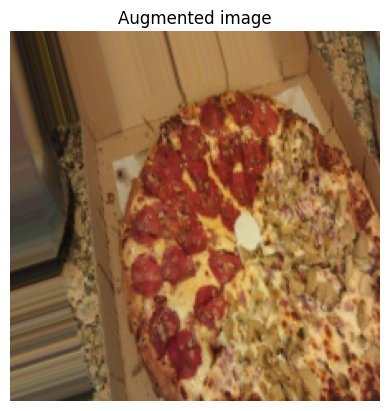

In [20]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [21]:
with tf.device('/GPU:0'):  # Use the first GPU
    model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    history_7 = model1.fit(train_data_augmented, # now the augmented data is shuffled
                            epochs=1,
                            steps_per_epoch=len(train_data_augmented),
                            validation_data=test_data,
                            validation_steps=len(test_data))

47/47 [==============================] - 14s 284ms/step - loss: 0.9165 - accuracy: 0.5453 - val_loss: 0.6731 - val_accuracy: 0.7840


<Axes: >

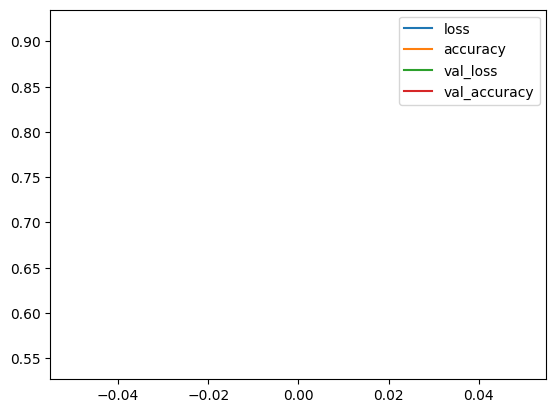

In [22]:
pd.DataFrame(history_7.history).plot()


In [23]:
train_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

Found 1500 images belonging to 2 classes.


# tf Data Augmentation


In [24]:
images,labels = train_data.next()
images = images.astype(np.uint8)
labels = labels.astype(np.uint8)

In [25]:
random_nb = random.randint(0,len(images)-1)
image=images[random_nb]

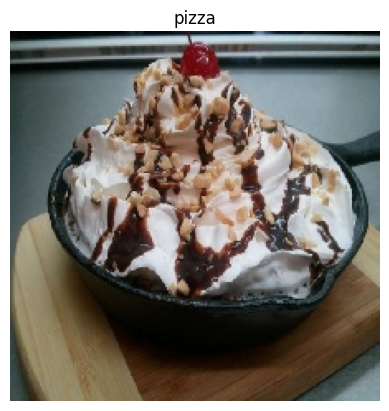

In [26]:
plt.imshow(image)
plt.title(f"{class_names[labels[random_nb]]}");
plt.axis(False);

In [27]:
image.shape

(224, 224, 3)

In [28]:
from keras import layers
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

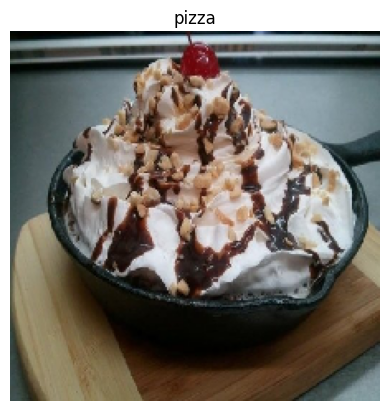

In [29]:
rescaled_image = resize_and_rescale(image)
plt.imshow(rescaled_image)
plt.title(class_names[labels[0]])
plt.axis(False);

In [30]:
print(f' min and max of image {rescaled_image.numpy().min()} and {rescaled_image.numpy().max()}')

 min and max of image 0.0 and 1.0


In [31]:
import warnings

warnings.filterwarnings('ignore')  # Suppress all warnings
# Or, to be more specific:
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress only UserWarnings


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

In [32]:
# Add the image to a batch
random_nb = random.randint(0,len(images)-1)
image=images[random_nb]
image = tf.cast(tf.expand_dims(image,0), tf.uint8)

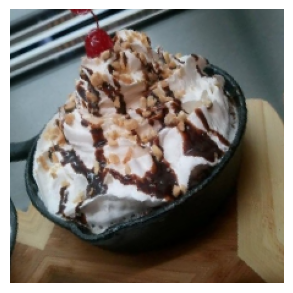

In [33]:



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set minimum logging level to 3 (ERROR)

plt.figure(figsize=(12, 12))
for i in range(1):
  augmented_image = data_augmentation(rescaled_image)
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(augmented_image)
  plt.axis("off")

In [34]:
def data_pipeline:

SyntaxError: invalid syntax (47551001.py, line 1)

In [ ]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3),activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3),activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

In [ ]:
with tf.device('/GPU:0'):  # Use the first GPU
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    history = model.fit(train_data, # now the augmented data is shuffled
                            epochs=10,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data))

In [ ]:
pd.DataFrame(history.history['accuracy']).plot();

In [ ]:
history.history